<a href="https://colab.research.google.com/github/tugcegurbuz/NMA-Stringer-Orientation-Decoding/blob/master/Pod4_Stringer_Orientation_Decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NMA Summer School Project: How Behavior Affects Visual Processing In Mouse V1 Area?

Busra Tugce Gurbuz, Zhewen He, Andrey Bukharev

T.A.: Arash Ashrafnejad

Mentors: Joshua Glaser, Kohitij Kar

---
**Project Description:**

**Scientific question:** Can we decode the perceived orientation information from the V1 area using calcium imaging data during mouse running behavior?

**Brief scientific background:** As described in Stringer et al., (2019), mainly two types of signals are encoded in V1, namely the sensory and behavioral signals. Here, we propose a decoding approach to understand how behavioral signals impact orientation decoding in the V1 area.

**Analysis:** We separated our data into moving and not moving trials by using standard error of the mean of running data as a threshold. To reduce the dimension of our data to 200, we performed PCA. Then, applied linear regression (with and without PCA), SVM approach (without PCA), and tried feedforward neuronal network (with PCA) for both moving and not moving data.

**Conclusions:** We observed that moving models predict perceived orientation better, which means that moving behavior somehow facilitates orientation perception. The next step might be explaining how moving facilitates orientation perception by using a mechanistic model.

# Loading of Stringer orientations data

This part of the code is recruited by [NMA tutorials](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/load_stringer_orientations.ipynb)

In [184]:
#@title Data retrieval
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"


if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [185]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [186]:
#@title Data loading
import numpy as np
dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])


Data:
* `dat['sresp']`: the neural response data (23589, 4598)
* `dat['xyz']`: three-dimensional position of each neuron in the brain (3, 23589) 
* `dat['run']`: the running speed of the animal in a.u. (4598, )
* `dat['istim']`: the orientations shown on each trial (from 0 to 2*np.pi) (4598, )

* `dat['u_spont']`: neurons by 128, the weights for the top 128 principal components of spontaneous activity. Unit norm. (23589, 128)
* `dat['v_spont']`: 128 by 910, the timecourses for the top 128 PCs of spont activity.
* `dat['u_spont'] @ dat['v_spont']`: a reconstruction of the spontaneous activity for 910 timepoints interspersed throughout the recording.
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.


#Exploring The Data

This part of the code is recruited by [NMA tutorials](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/load_stringer_orientations.ipynb)

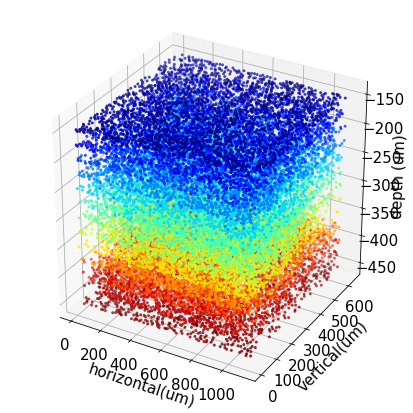

In [ ]:
 # @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1],z[::-1], 'o', s = 4, c = cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel = 'vertical(um)', zlabel='depth (um)');

Text(0, 0.5, 'running speed')

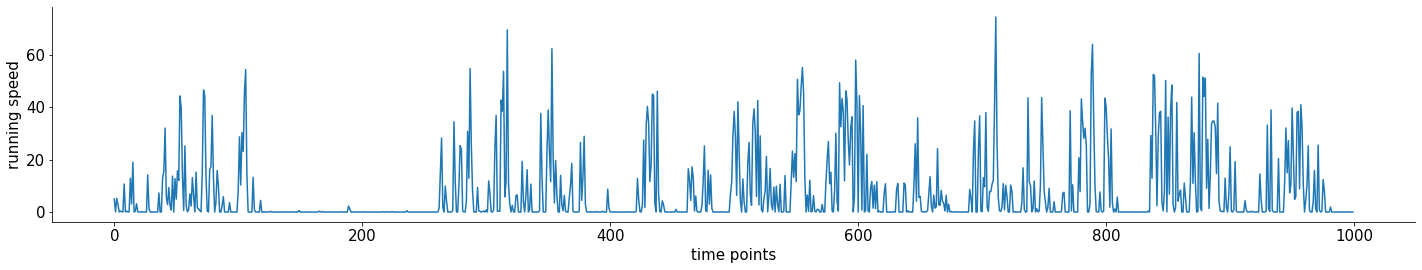

In [ ]:
# @title running behavior per timepoint plot
plt.plot(dat['run'][0:1000])
plt.xlabel('time points')
plt.ylabel('running speed')

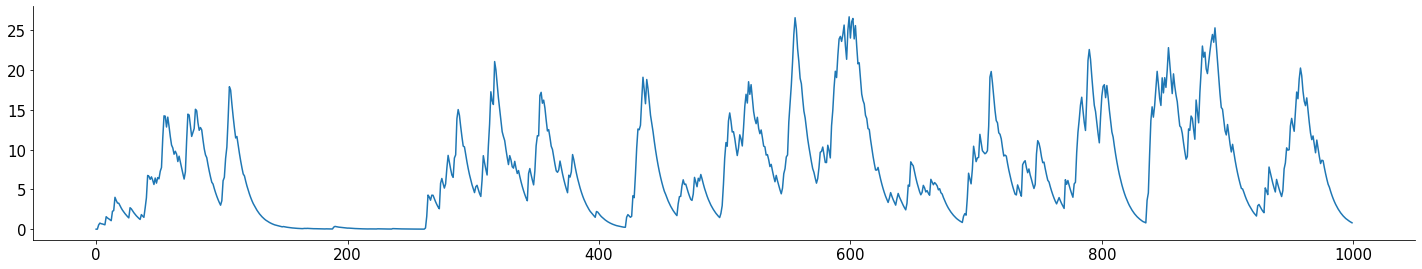

In [ ]:
filtered_speed = np.zeros(dat['run'].shape)
alpha = 0.9
for ind in range(1, len(dat['run'])):
  filtered_speed[ind] =   filtered_speed[ind - 1] * alpha + dat['run'][ind] * (1-alpha)
plt.plot(filtered_speed[0:1000])

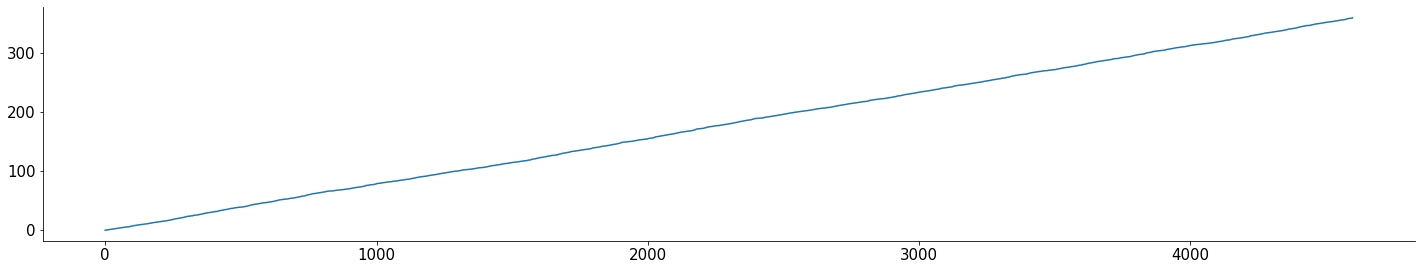

In [ ]:
unique_oris = np.unique(dat['istim'])
sorted_unique_oris = np.sort(unique_oris)
deg_sorted_unique_oris = sorted_unique_oris * 180 / np.pi
plt.plot(deg_sorted_unique_oris)

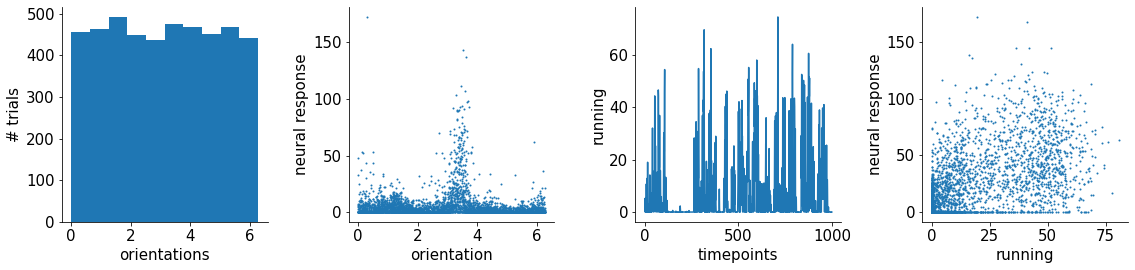

In [ ]:
#@title Basic data properties using plot, hist and scatter
ax = plt.subplot(1,5,1)
plt.hist(dat['istim'])
ax.set(xlabel='orientations', ylabel = '# trials')

ax = plt.subplot(1,5,2)
plt.scatter(dat['istim'], dat['sresp'][1000], s= 1)
ax.set(xlabel = 'orientation', ylabel = 'neural response')

ax = plt.subplot(1,5,3)
plt.plot(dat['run'][:1000])
ax.set(xlabel = 'timepoints', ylabel = 'running')

ax = plt.subplot(1,5,4)
plt.scatter(dat['run'], dat['sresp'][20998], s= 1)
ax.set(xlabel = 'running', ylabel = 'neural response')

plt.show()

In [ ]:
#@title take PCA of neuronal response after preparing data by z-score
from scipy.stats import zscore
from sklearn.decomposition import PCA 
Z = zscore(dat['sresp'], axis=1)
X_pca = PCA(n_components = 200).fit_transform(Z.T)

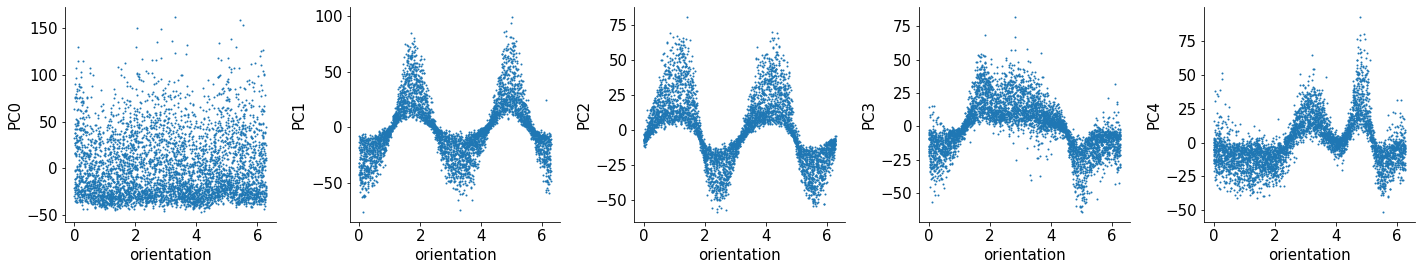

In [ ]:
#@title plot PCs as function of stimulus orientation
for j in range(5):
  ax = plt.subplot(1,5,j+1)
  plt.scatter(dat['istim'], X_pca[:,j], s = 1)
  ax.set(xlabel='orientation', ylabel = 'PC%d'%j)
plt.show()

In [ ]:
#@title run a manifold embedding algorithm (UMAP) in two or three dimensions.
# it is a nonlinear dimensionality reduction algorithm 
!pip install umap-learn
from umap import UMAP
ncomp = 2# try 2, then try 3
xinit = 3 * zscore(X_pca[:,:ncomp], axis=0)
embed = UMAP(n_components=ncomp, init =  xinit, n_neighbors = 25, 
             metric = 'correlation', transform_seed = 42).fit_transform(X_pca)

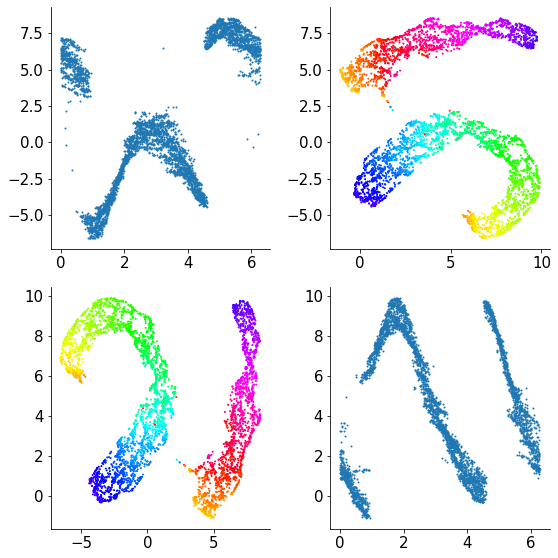

In [ ]:
plt.figure(figsize=(8,8))
for i in range(ncomp):
  for j in range(ncomp):
    plt.subplot(ncomp,ncomp, j + ncomp*i + 1)
    if i==j:
      plt.scatter(dat['istim'], embed[:,i], s  = 1)
    else:
      plt.scatter(embed[:,j], embed[:,i], s  = 1, c= dat['istim'], cmap = 'hsv')
# Is that a Mobius strip? A good project would be to try to figure out why (I don't know). 

# Divide trials w.r.t. running speed

In [187]:
#@title Divide trials w.r.t. running speed

#set the threshold: standart error of the mean
sdev_run = np.std(dat['run'])
threshold_run = np.ceil(sdev_run / np.sqrt(len(dat['run'])))
print(f'Threshold value for running speed is {threshold_run}')

#extract the moving and non-moving inds
moving_inds = dat['run'] > threshold_run
non_moving_inds = dat['run'] <= threshold_run
print(f'The number of not moving trials {np.sum(non_moving_inds)}')
print(f'The number of moving trials {np.sum(moving_inds)}')

#extract moving/non-moving neuronal response
moving_nresp = dat['sresp'][:, moving_inds]
non_moving_nresp = dat['sresp'][:, non_moving_inds]

#extract moving/non-moving orientation trials
moving_oris = dat['istim'][moving_inds]
non_moving_oris = dat['istim'][non_moving_inds]

Threshold value for running speed is 1.0
The number of not moving trials 2407
The number of moving trials 2191


# Apply PCA to moving and non-moving data

In [188]:
#@title apply PCA to moving and non-moving neuronal response

from scipy.stats import zscore
from sklearn.decomposition import PCA 
Z_moving = zscore(moving_nresp, axis=1)
X_moving_pca = PCA(n_components = 200).fit_transform(Z_moving.T)

Z_non_moving = zscore(non_moving_nresp, axis=1)
X_non_moving_pca = PCA(n_components = 200).fit_transform(Z_non_moving.T)

#Linear Regression Models

### Fit Simple Linear Regression

In [ ]:
#@title fit simple linear regression y = x*beta (no intercept)
from sklearn import datasets, linear_model, metrics 
from sklearn.model_selection import train_test_split 
Y = dat['istim']
Z = dat['run']
X = dat['sresp']
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X_pca, Y, Z, test_size=0.2, random_state=1)
reg_model = linear_model.LinearRegression() 
reg_model.fit(X_train,y_train)

NameError: ignored

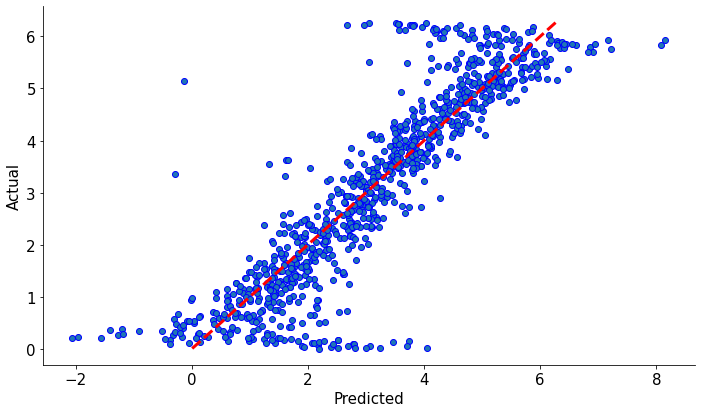

In [ ]:
y_predicted = reg_model.predict(X_test)
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(y_predicted, y_test, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [ ]:
# model evaluation for testing set
#mean absolute error
mae = metrics.mean_absolute_error(y_test, y_predicted)
#mean squared error
mse = metrics.mean_squared_error(y_test, y_predicted)
#r square
r2 = metrics.r2_score(y_test, y_predicted)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

The model performance for testing set
--------------------------------------
MAE is 0.5675563810503834
MSE is 0.736543970279477
R2 score is 0.7829582431104287


In [ ]:
#Perform CV
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(reg_model, X_pca, Y, Z, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (cv_score.mean(), cv_score.std() * 2))

Accuracy: 0.77 (+/- 0.08)


### Non-moving trials without PCA

In [ ]:
#@title linear regression by non-moving trials to predict orientation without PCA
from sklearn import datasets, linear_model, metrics 
from sklearn.model_selection import train_test_split 
Y_non_moving = non_moving_oris
print(Y_non_moving.shape)
X_non_moving = non_moving_nresp.T 
print(X_non_moving.shape)
X_train, X_test, y_train, y_test = train_test_split(X_non_moving, Y_non_moving, test_size=0.2, random_state=1)
reg_model_non_moving = linear_model.LinearRegression() 
reg_model_non_moving.fit(X_train,y_train)

(2407,)
(2407, 23589)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

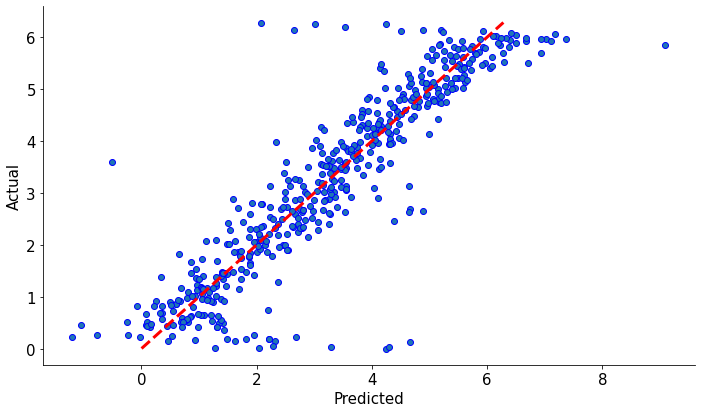

In [ ]:
y_predicted = reg_model_non_moving.predict(X_test)
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(y_predicted, y_test, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [ ]:
# model evaluation for testing set
#mean absolute error
mae = metrics.mean_absolute_error(y_test, y_predicted)
#mean squared error
mse = metrics.mean_squared_error(y_test, y_predicted)
#r square
r2 = metrics.r2_score(y_test, y_predicted)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

The model performance for testing set
--------------------------------------
MAE is 0.5132426000902942
MSE is 0.6627237290425892
R2 score is 0.7958150853894226


In [ ]:
#Perform CV
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(reg_model_non_moving, X_non_moving, Y_non_moving, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (cv_score.mean(), cv_score.std() * 2))

Accuracy: 0.79 (+/- 0.11)


### Moving trials without PCA

In [ ]:
#@title linear regression by moving trials to predict orientation without PCA
from sklearn import datasets, linear_model, metrics 
from sklearn.model_selection import train_test_split 
Y_moving = moving_oris
print(Y_moving.shape)
X_moving = moving_nresp.T 
print(X_moving.shape)
X_train, X_test, y_train, y_test = train_test_split(X_moving, Y_moving, test_size=0.2, random_state=1)
reg_model_moving = linear_model.LinearRegression() 
reg_model_moving.fit(X_train,y_train)

(2191,)
(2191, 23589)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

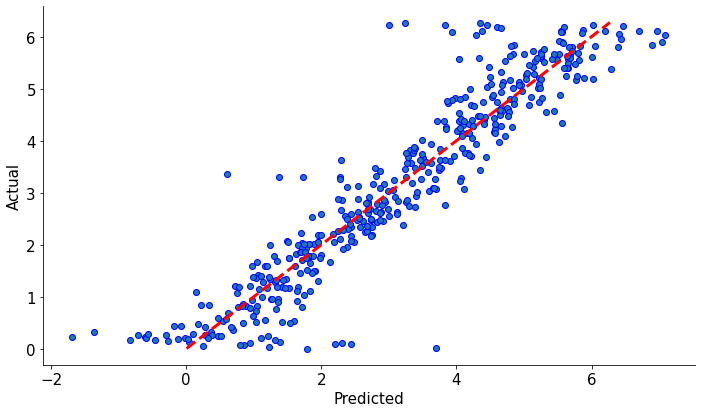

In [ ]:
y_predicted = reg_model_moving.predict(X_test)
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(y_predicted, y_test, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [ ]:
# model evaluation for testing set
#mean absolute error
mae = metrics.mean_absolute_error(y_test, y_predicted)
#mean squared error
mse = metrics.mean_squared_error(y_test, y_predicted)
#r square
r2 = metrics.r2_score(y_test, y_predicted)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

The model performance for testing set
--------------------------------------
MAE is 0.4503744521770049
MSE is 0.4366458514946802
R2 score is 0.8716945130678031


In [ ]:
#Perform CV
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(reg_model_moving, X_moving, Y_moving, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (cv_score.mean(), cv_score.std() * 2))

Accuracy: 0.82 (+/- 0.09)


### Moving trials with PCA

In [ ]:
#@title linear regression by moving trials to predict orientation with PCA
from sklearn import datasets, linear_model, metrics 
from sklearn.model_selection import train_test_split 
Y_moving = moving_oris
print(Y_moving.shape)
X_moving = X_moving_pca
print(X_moving.shape)
X_train_moving, X_test_moving, y_train_moving, y_test_moving = train_test_split(X_moving, Y_moving, test_size=0.2, random_state=1)
reg_model_moving = linear_model.LinearRegression() 
reg_model_moving.fit(X_train_moving,y_train_moving)

(2191,)
(2191, 200)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

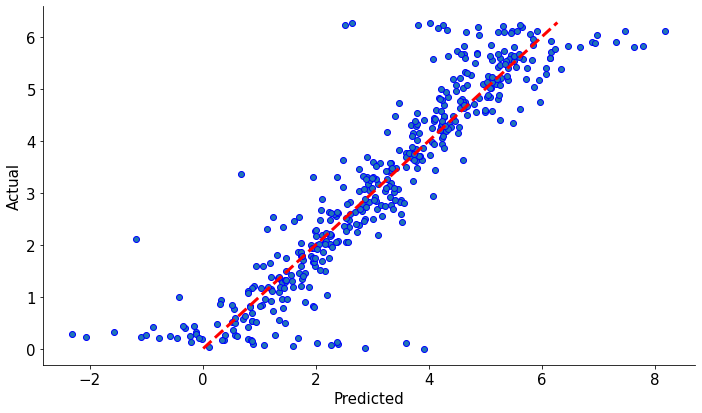

In [ ]:
y_predicted_moving = reg_model_moving.predict(X_test_moving)
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(y_predicted_moving, y_test_moving, edgecolors=(0, 0, 1))
ax.plot([y_test_moving.min(), y_test_moving.max()], [y_test_moving.min(), y_test_moving.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [ ]:
# model evaluation for testing set
#mean absolute error
mae = metrics.mean_absolute_error(y_test, y_predicted)
#mean squared error
mse = metrics.mean_squared_error(y_test, y_predicted)
#r square
r2 = metrics.r2_score(y_test, y_predicted)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

The model performance for testing set
--------------------------------------
MAE is 0.5064179246359906
MSE is 0.6053876921020303
R2 score is 0.8221108425695045


### Non-moving trials with PCA

In [ ]:
#@title linear regression by not moving trials to predict orientation with PCA
from sklearn import datasets, linear_model, metrics 
from sklearn.model_selection import train_test_split 
Y_non_moving = non_moving_oris
print(Y_non_moving.shape)
X_non_moving = X_non_moving_pca
print(X_non_moving.shape)
X_train_non_moving, X_test_non_moving, y_train_non_moving, y_test_non_moving = train_test_split(X_non_moving, Y_non_moving, test_size=0.2, random_state=1)
reg_model_non_moving = linear_model.LinearRegression() 
reg_model_non_moving.fit(X_train_non_moving,y_train_non_moving)

(2407,)
(2407, 200)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

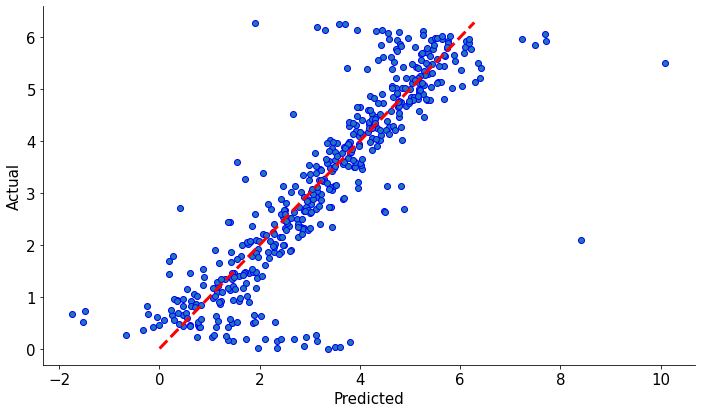

In [ ]:
y_predicted_non_moving = reg_model_non_moving.predict(X_test_non_moving)
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(y_predicted_non_moving, y_test_non_moving, edgecolors=(0, 0, 1))
ax.plot([y_test_non_moving.min(), y_test_non_moving.max()], [y_test_non_moving.min(), y_test_non_moving.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [ ]:
# model evaluation for testing set
#mean absolute error
mae = metrics.mean_absolute_error(y_test_non_moving, y_predicted_non_moving)
#mean squared error
mse = metrics.mean_squared_error(y_test_non_moving, y_predicted_non_moving)
#r square
r2 = metrics.r2_score(y_test_non_moving, y_predicted_non_moving)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

The model performance for testing set
--------------------------------------
MAE is 0.5724346604814766
MSE is 0.8513233165858196
R2 score is 0.7377076282537964


Overall, linear regression models with and without PCA showed higher orientation prediction performance for moving trials than not moving. (Based on $R^2$ comparisions)

#Test data with each other

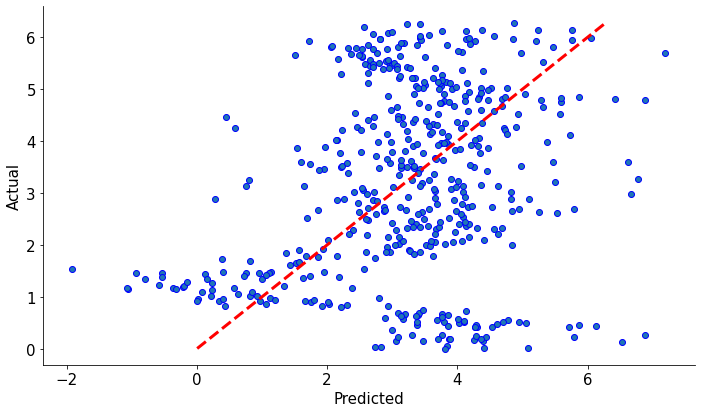

The model performance for testing set
--------------------------------------
MAE is 1.5825378608413605
MSE is 4.008841035911025
R2 score is -0.2351223122603301


In [ ]:
moving_on_non_moving = reg_model_moving.predict(X_test_non_moving)
#plot
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(moving_on_non_moving, y_test_non_moving, edgecolors=(0, 0, 1))
ax.plot([y_test_non_moving.min(), y_test_non_moving.max()], [y_test_non_moving.min(), y_test_non_moving.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

# model evaluation for testing set
#mean absolute error
mae = metrics.mean_absolute_error(y_test_non_moving, moving_on_non_moving)
#mean squared error
mse = metrics.mean_squared_error(y_test_non_moving, moving_on_non_moving)
#r square
r2 = metrics.r2_score(y_test_non_moving, moving_on_non_moving)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

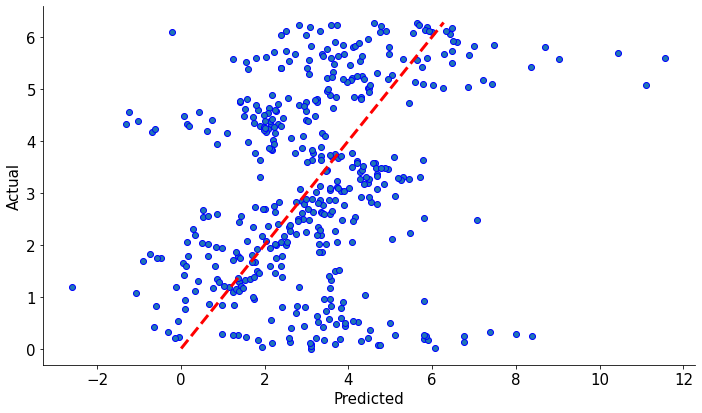

The model performance for testing set
--------------------------------------
MAE is 1.7294539792943129
MSE is 5.068814387455609
R2 score is -0.4894374833178532


In [ ]:
non_moving_on_moving = reg_model_non_moving.predict(X_test_moving)

#plot
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(non_moving_on_moving, y_test_moving, edgecolors=(0, 0, 1))
ax.plot([y_test_moving.min(), y_test_moving.max()], [y_test_moving.min(), y_test_moving.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()
# model evaluation for testing set
#mean absolute error
mae = metrics.mean_absolute_error(y_test_moving, non_moving_on_moving)
#mean squared error
mse = metrics.mean_squared_error(y_test_moving, non_moving_on_moving)
#r square
r2 = metrics.r2_score(y_test_moving, non_moving_on_moving)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

#SVM Models

In [ ]:
#@title convert continuous stimulus into 33 unique orientations 
Y_deg = Y * 180 / np.pi
Y_33deg = (Y_deg//11)
Y_deg = Y_33deg * 11 
Y_deg = np.int_(Y_deg)
Y_33deg = np.int_(Y_33deg)
print(Y_33deg)
print(Y_deg)
Y_bin = np.zeros(len(Y_deg))
for i in range(len(Y_deg)):
  if Y_deg[i] < 180:
    Y_bin[i] = 0
  elif Y_deg[i] >= 180:
    Y_bin[i] = 1
Y_bin = np.int_(Y_bin)
print(Y_bin)
Y_bin_non_moving = Y_bin[non_moving_inds]
Y_bin_moving = Y_bin[moving_inds]
Y_33deg_non_moving = Y_33deg[non_moving_inds]
Y_33deg_moving = Y_33deg[moving_inds]

NameError: ignored

### Non-moving trials

In [ ]:
#@title apply linear SVM for non-moving X without pca (binary)
X_train, X_test, y_train, y_test = train_test_split(X_non_moving, Y_bin_non_moving, test_size=0.2, random_state=1)
from sklearn import svm
classifier = svm.SVC(kernel='linear')
print(X_non_moving.shape)
classifier.fit(X_train,y_train)
y_predict = classifier.predict(X_test)

#assess svm 
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_predict))
print("Precision:",metrics.precision_score(y_test, y_predict))
print("Recall:",metrics.recall_score(y_test, y_predict))

support_vectors = classifier.support_vectors_

In [ ]:
#@title apply polynomial SVM for non-moving X without pca (binary)
X_train, X_test, y_train, y_test = train_test_split(X_non_moving, Y_bin_non_moving, test_size=0.2, random_state=1)
from sklearn import svm
classifier = svm.SVC(kernel='poly')
print(X_non_moving.shape)
classifier.fit(X_train,y_train)
y_predict = classifier.predict(X_test)

#assess svm 
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_predict))
print("Precision:",metrics.precision_score(y_test, y_predict))
print("Recall:",metrics.recall_score(y_test, y_predict))

support_vectors = classifier.support_vectors_

In [ ]:
#@title apply rbf SVM for non-moving X without pca (binary)
X_train, X_test, y_train, y_test = train_test_split(X_non_moving, Y_bin_non_moving, test_size=0.2, random_state=1)
from sklearn import svm
classifier = svm.SVC(kernel='rbf')
print(X_non_moving.shape)
classifier.fit(X_train,y_train)
y_predict = classifier.predict(X_test)

#assess svm 
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_predict))
print("Precision:",metrics.precision_score(y_test, y_predict))
print("Recall:",metrics.recall_score(y_test, y_predict))

support_vectors = classifier.support_vectors_

In [ ]:
#@title apply multi-class SVM for non-moving X without pca
X_train, X_test, y_train, y_test = train_test_split(X_non_moving, Y_33deg_non_moving, test_size=0.2, random_state=1)
#one vs. one
ovo_lin = svm.SVC(decision_function_shape='ovo',kernel = 'linear')
ovo_poly = svm.SVC(decision_function_shape='ovo',kernel = 'poly')
ovo_rbf = svm.SVC(decision_function_shape='ovo',kernel = 'rbf')
ovo_lin.fit(X_train,y_train)
ovo_poly.fit(X_train,y_train)
ovo_rbf.fit(X_train,y_train)
y_predict_lin = ovo_lin.predict(X_test)
y_predict_poly = ovo_poly.predict(X_test)
y_predict_rbf = ovo_rbf.predict(X_test)
print("Linear ovo Accuracy:",metrics.accuracy_score(y_test, y_predict_lin))
print("Polynomial ovo Accuracy:",metrics.accuracy_score(y_test, y_predict_poly))
print("RBF ovo Accuracy:",metrics.accuracy_score(y_test, y_predict_rbf))

#one vs. rest
ovr_lin = svm.SVC(decision_function_shape='ovr',kernel = 'linear')
ovr_poly = svm.SVC(decision_function_shape='ovr',kernel = 'poly')
ovr_rbf = svm.SVC(decision_function_shape='ovr',kernel = 'rbf')
ovr_lin.fit(X_train,y_train)
ovr_poly.fit(X_train,y_train)
ovr_rbf.fit(X_train,y_train)
y_predict_lin = ovr_lin.predict(X_test)
y_predict_poly = ovr_poly.predict(X_test)
y_predict_rbf = ovr_rbf.predict(X_test)
print("Linear ovr Accuracy:",metrics.accuracy_score(y_test, y_predict_lin))
print("Polynomial ovr Accuracy:",metrics.accuracy_score(y_test, y_predict_poly))
print("RBF ovr Accuracy:",metrics.accuracy_score(y_test, y_predict_rbf))

### Moving trials

In [ ]:
#@title apply linear SVM for moving X without pca (binary)
X_train, X_test, y_train, y_test = train_test_split(X_moving, Y_bin_moving, test_size=0.2, random_state=1)
from sklearn import svm
classifier = svm.SVC(kernel='linear')
print(X_non_moving.shape)
classifier.fit(X_train,y_train)
y_predict = classifier.predict(X_test)

#assess svm 
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_predict))
print("Precision:",metrics.precision_score(y_test, y_predict))
print("Recall:",metrics.recall_score(y_test, y_predict))

support_vectors = classifier.support_vectors_

In [ ]:
#@title apply polynomial SVM for moving X without pca (binary)
X_train, X_test, y_train, y_test = train_test_split(X_moving, Y_bin_moving, test_size=0.2, random_state=1)
from sklearn import svm
classifier = svm.SVC(kernel='poly')
print(X_non_moving.shape)
classifier.fit(X_train,y_train)
y_predict = classifier.predict(X_test)

#assess svm 
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_predict))
print("Precision:",metrics.precision_score(y_test, y_predict))
print("Recall:",metrics.recall_score(y_test, y_predict))

support_vectors = classifier.support_vectors_

In [ ]:
#@title apply rbf SVM for moving X without pca (binary)
X_train, X_test, y_train, y_test = train_test_split(X_moving, Y_bin_moving, test_size=0.2, random_state=1)
from sklearn import svm
classifier = svm.SVC(kernel='rbf')
print(X_non_moving.shape)
classifier.fit(X_train,y_train)
y_predict = classifier.predict(X_test)

#assess svm 
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_predict))
print("Precision:",metrics.precision_score(y_test, y_predict))
print("Recall:",metrics.recall_score(y_test, y_predict))

support_vectors = classifier.support_vectors_

In [ ]:
#@title apply multi-class SVM for moving X without pca
X_train, X_test, y_train, y_test = train_test_split(X_moving, Y_33deg_moving, test_size=0.2, random_state=1)
#one vs. one
ovo_lin = svm.SVC(decision_function_shape='ovo',kernel = 'linear')
ovo_poly = svm.SVC(decision_function_shape='ovo',kernel = 'poly')
ovo_rbf = svm.SVC(decision_function_shape='ovo',kernel = 'rbf')
ovo_lin.fit(X_train,y_train)
ovo_poly.fit(X_train,y_train)
ovo_rbf.fit(X_train,y_train)
y_predict_lin = ovo_lin.predict(X_test)
y_predict_poly = ovo_poly.predict(X_test)
y_predict_rbf = ovo_rbf.predict(X_test)
print("Linear ovo Accuracy:",metrics.accuracy_score(y_test, y_predict_lin))
print("Polynomial ovo Accuracy:",metrics.accuracy_score(y_test, y_predict_poly))
print("RBF ovo Accuracy:",metrics.accuracy_score(y_test, y_predict_rbf))

#one vs. rest
ovr_lin = svm.SVC(decision_function_shape='ovr',kernel = 'linear')
ovr_poly = svm.SVC(decision_function_shape='ovr',kernel = 'poly')
ovr_rbf = svm.SVC(decision_function_shape='ovr',kernel = 'rbf')
ovr_lin.fit(X_train,y_train)
ovr_poly.fit(X_train,y_train)
ovr_rbf.fit(X_train,y_train)
y_predict_lin = ovr_lin.predict(X_test)
y_predict_poly = ovr_poly.predict(X_test)
y_predict_rbf = ovr_rbf.predict(X_test)
print("Linear ovr Accuracy:",metrics.accuracy_score(y_test, y_predict_lin))
print("Polynomial ovr Accuracy:",metrics.accuracy_score(y_test, y_predict_poly))
print("RBF ovr Accuracy:",metrics.accuracy_score(y_test, y_predict_rbf))

#Simple Feedforward Network

In [189]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [166]:
#@title Define feedforward pass
#nn.linear(number of features, hidden unit)
#nn.linear(hidden unit, output features)
class feedforwardModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(200, 8),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(8, 1),
        nn.ReLU())

  def forward(self, X):
    return self.net(X)


In [167]:
#@title Define function for training
def train(x, y, model, optimizer, loss, epoch_num):
  losses = []
  for epoch in range(epoch_num):
    y_pred = model(x.float())
    l = loss(y_pred.float(), y.unsqueeze(-1).float())
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch number {epoch}: {l.item()}')
    losses.append(l.item())

  return model, losses

In [168]:
#@title Define the loss and optimizer
#object
model = feedforwardModel()

#Loss Function
loss = nn.MSELoss()
#Optimizer: SGD with L2 regularization
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-4, 
                            momentum=0.9, weight_decay=1)

In [169]:
#@title Define the test function
def validation(x, y, model, loss):
    y_pred = model(x.float())
    l = loss(y_pred.float(), y.unsqueeze(-1).float())
    mean_loss = torch.mean(l)
    print(f'Mean loss is {mean_loss}')
    return mean_loss, y_pred

### Not Moving Trials

In [170]:
#@title Split the data by using sklearn
from sklearn import datasets, linear_model, metrics 
from sklearn.model_selection import train_test_split 
#Not moving trials
Y_non_moving = non_moving_oris
print(Y_non_moving.shape)
X_non_moving = X_non_moving_pca 
print(X_non_moving.shape)
X_train_non_moving, X_test_non_moving, y_train_non_moving, y_test_non_moving = train_test_split(X_non_moving, Y_non_moving, test_size=0.2, random_state=1)


(2407,)
(2407, 200)


In [171]:
#@title Convert the data to tensors
X_train_non_moving, y_train_non_moving, X_test_non_moving, y_test_non_moving = map(torch.tensor, (X_train_non_moving, y_train_non_moving, X_test_non_moving, y_test_non_moving))
print(f'Shape of the training input samples {X_train_non_moving.shape}')
print(f'Shape of the test input samples {X_test_non_moving.shape}')
print(f'Shape of the training labels {y_train_non_moving.shape}')
print(f'Shape of the test labels {y_test_non_moving.shape}')

Shape of the training input samples torch.Size([1925, 200])
Shape of the test input samples torch.Size([482, 200])
Shape of the training labels torch.Size([1925])
Shape of the test labels torch.Size([482])


In [172]:
#@title Normalize the training
X_train_non_moving -= torch.mean(X_train_non_moving, axis=0)
X_train_non_moving /= torch.std(X_train_non_moving, axis=0)

In [173]:
#@title Perform training
trained_model_non_moving, train_losses_non_moving = train(X_train_non_moving, y_train_non_moving, model, optimizer, loss, 5000)

Epoch number 0: 12.77708911895752
Epoch number 100: 12.605146408081055
Epoch number 200: 11.485832214355469
Epoch number 300: 8.190764427185059
Epoch number 400: 5.632289409637451
Epoch number 500: 4.056746959686279
Epoch number 600: 3.188302993774414
Epoch number 700: 2.7672204971313477
Epoch number 800: 2.408174514770508
Epoch number 900: 2.2196733951568604
Epoch number 1000: 2.215545177459717
Epoch number 1100: 2.1395184993743896
Epoch number 1200: 2.04359769821167
Epoch number 1300: 2.0776472091674805
Epoch number 1400: 1.9565105438232422
Epoch number 1500: 1.9517265558242798
Epoch number 1600: 1.9318585395812988
Epoch number 1700: 1.9493684768676758
Epoch number 1800: 1.8863252401351929
Epoch number 1900: 1.8726511001586914
Epoch number 2000: 1.8152265548706055
Epoch number 2100: 1.7671011686325073
Epoch number 2200: 1.7754673957824707
Epoch number 2300: 1.734345555305481
Epoch number 2400: 1.8051584959030151
Epoch number 2500: 1.7681156396865845
Epoch number 2600: 1.6236267089843

Text(0, 0.5, 'MSE loss')

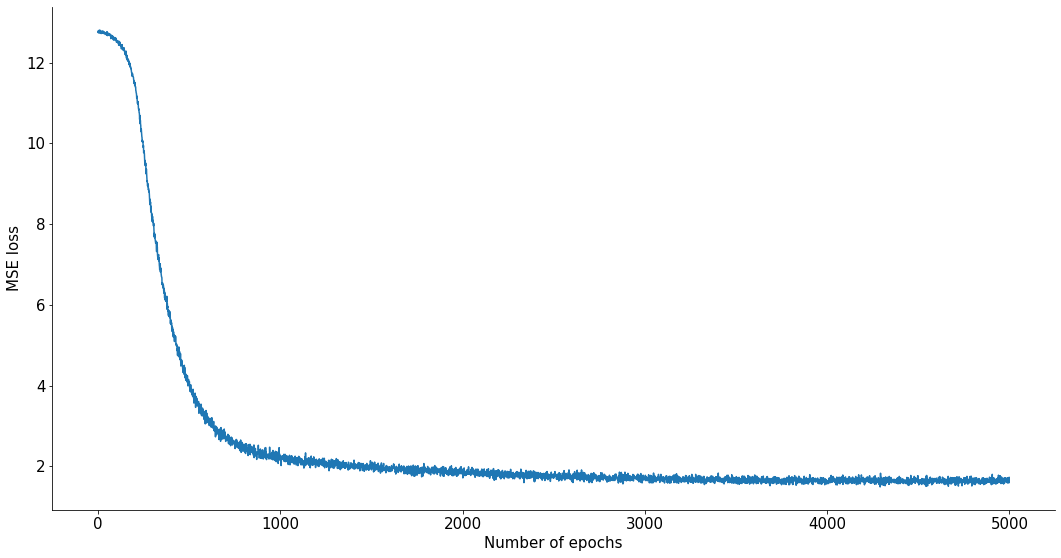

In [192]:
#@title Plot the training loss over time
plt.figure(figsize=(15, 8))
plt.plot(train_losses_non_moving)
plt.xlabel('Number of epochs')
plt.ylabel('MSE loss')

In [175]:
#@title Normalize the testing
X_test_non_moving -= torch.mean(X_train_non_moving, axis=0)
X_test_non_moving /= torch.std(X_train_non_moving, axis=0)

In [200]:
#@title Perform testing
mean_mse_non_moving, y_pred_non_moving = validation(X_test_non_moving, y_test_non_moving, trained_model_non_moving, loss)

Mean loss is 188.43194580078125


In [202]:
#@title Calculate R2
r2_non_moving = metrics.r2_score(y_test_non_moving.detach(), y_pred_non_moving.detach())
print(r2_non_moving)

-57.055802320055776


Text(0.5, 1.0, 'Average MSE on test set: 182.78')

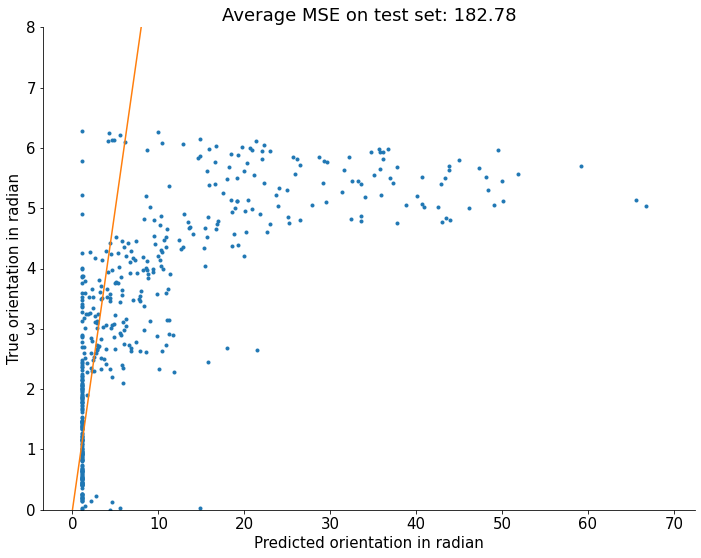

In [177]:
#@title Plot the results of testing
plt.figure(figsize=(10, 8))
plt.plot(y_pred_non_moving.detach(), y_test_non_moving.detach(), '.')
#Plot identity line how well it fits
x_dummy = range(70)
plt.plot(x_dummy)
plt.ylim([0, 8])
plt.xlabel('Predicted orientation in radian')
plt.ylabel('True orientation in radian')
plt.title('Average MSE on test set: %.2f' % mean_mse_non_moving)

### Moving Trials

In [178]:
#@title Split the data by using sklearn
Y_moving = moving_oris
print(Y_moving.shape)
X_moving = X_moving_pca  
print(X_moving.shape)
X_train_moving, X_test_moving, y_train_moving, y_test_moving = train_test_split(X_moving, Y_moving, test_size=0.2, random_state=1)


(2191,)
(2191, 200)


In [179]:
#@title Convert the data to tensors
X_train_moving, y_train_moving, X_test_moving, y_test_moving = map(torch.tensor, (X_train_moving, y_train_moving, X_test_moving, y_test_moving))
print(f'Shape of the training input samples {X_train_moving.shape}')
print(f'Shape of the test input samples {X_test_moving.shape}')
print(f'Shape of the training labels {y_train_moving.shape}')
print(f'Shape of the test labels {y_test_moving.shape}')

Shape of the training input samples torch.Size([1752, 200])
Shape of the test input samples torch.Size([439, 200])
Shape of the training labels torch.Size([1752])
Shape of the test labels torch.Size([439])


In [138]:
#@title Normalize the training data
X_train_moving -= torch.mean(X_train_moving, axis=0)
X_train_moving /= torch.std(X_train_moving, axis=0)

In [139]:
#@title Perform training
trained_model_moving, train_losses_moving = train(X_train_moving, y_train_moving, model, optimizer, loss, 5000)

Epoch number 0: 4.070504665374756
Epoch number 100: 2.8425803184509277
Epoch number 200: 2.084813117980957
Epoch number 300: 1.656601071357727
Epoch number 400: 1.3919471502304077
Epoch number 500: 1.355637550354004
Epoch number 600: 1.2512091398239136
Epoch number 700: 1.2279446125030518
Epoch number 800: 1.195953130722046
Epoch number 900: 1.2232905626296997
Epoch number 1000: 1.3201212882995605
Epoch number 1100: 1.2149345874786377
Epoch number 1200: 1.20636785030365
Epoch number 1300: 1.1942558288574219
Epoch number 1400: 1.2241113185882568
Epoch number 1500: 1.2832328081130981
Epoch number 1600: 1.1775152683258057
Epoch number 1700: 1.2103421688079834
Epoch number 1800: 1.2160824537277222
Epoch number 1900: 1.1661710739135742
Epoch number 2000: 1.2462468147277832
Epoch number 2100: 1.206815242767334
Epoch number 2200: 1.2103334665298462
Epoch number 2300: 1.2839621305465698
Epoch number 2400: 1.1511873006820679
Epoch number 2500: 1.2106144428253174
Epoch number 2600: 1.14875161647

Text(0, 0.5, 'MSE loss')

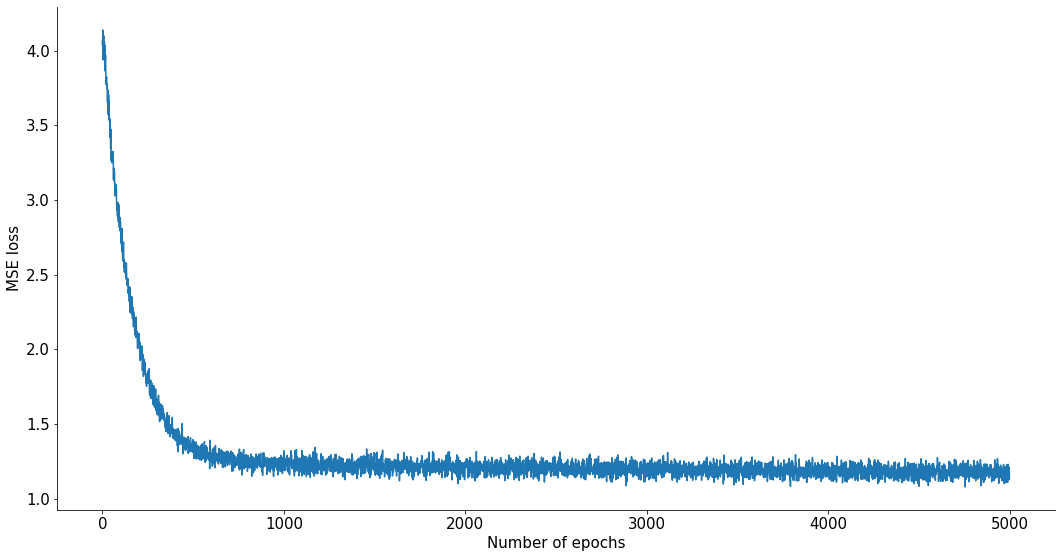

In [193]:
#@title Plot the training loss over time
plt.figure(figsize=(15, 8))
plt.plot(train_losses_moving)
plt.xlabel('Number of epochs')
plt.ylabel('MSE loss')

In [141]:
#@title Normalize the test data
X_test_moving -= torch.mean(X_train_moving, axis=0)
X_test_moving /= torch.std(X_train_moving, axis=0)

In [182]:
#@title Perform testing
mean_loss_moving, y_pred_moving = validation(X_test_moving, y_test_moving, trained_model_moving, loss)

Mean loss is 240.55465698242188


In [199]:
#@title Calculate R2
r2_moving = metrics.r2_score(y_test_moving.detach(), y_pred_moving.detach())
print(r2_moving)

-69.68539099494267


Moving test average loss: 3.44

Non-moving test average loss: 3.30

Text(0.5, 1.0, 'Average MSE on test set: 240.55')

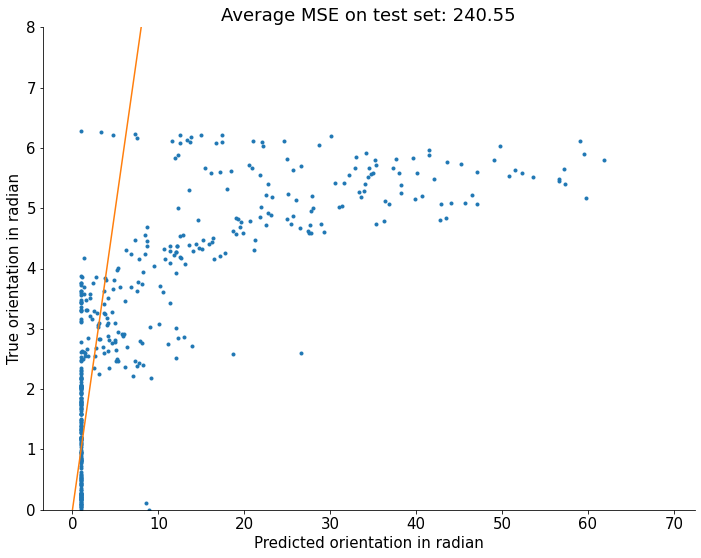

In [196]:
#@title Plot the results of testing
plt.figure(figsize=(10, 8))
plt.plot(y_pred_moving.detach(), y_test_moving.detach(), '.')
#Plot identity line how well it fits
x_dummy = range(70)
plt.plot(x_dummy)
plt.ylim([0, 8])
plt.xlabel('Predicted orientation in radian')
plt.ylabel('True orientation in radian')
plt.title('Average MSE on test set: %.2f' % mean_loss_moving)